# Autoregression DS chat

This [link](https://pythondata.com/forecasting-time-series-autoregression/) and this [one](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/) are very useful!

### What is autoregression?

Forecast (predict) time series data! As the word implies, it involves using known values in a time series to predict future values (i.e. regress on some last $N$ values of the time series via multiple linear regression, where each of  the last $N$ values in the series are the explanatory/predictor variables)

Formally, autoregression of order $k$, AR ($k$), on a time series $y \, (t)$ is defined as:

$y \,(t+1) = A + B_t \, y \, (t) + B_{t-1} \, y \, (t-1) + B_{t-2} \, y \, (t-2) + \dots + B_{t-k} \, y \, (t-k). $

Simple enough right?... But, **how many terms in the multiple regression do we keep**? To answer this we must look a little closer at what is happening. **For AR to be successful, there must be some periodicity, or some pattern, in the data** to enable forecasting of future data points. Autoregression turns to the **autocorrelation function** to answer the question of how many previous data points in the time series to use to predict future values.

### What is autocorrelation?

Formally, autocorrelation, for a continuous complex function $f$, is defined as:

$R_{ff} \, (\tau) = \int_{-\infty}^{\infty} f\,(t) \, f^{\star} (t - \tau) \, dt, $

where $\tau$ is a lag parameter with units of time and $f^{\star}$ is the complex conjugate of $f$. If your function is real valued, just ignore the $f^{\star}$. For a discrete function, the above equation becomes a simple sum,

$R_{ff} \, (\tau') = \sum_{i} f\,(t_i ) \, f\,(t_{i-\tau'}) $,

where here the lag $\tau'$ is an integer number.

In plain words, the above equation involves taking the function $f$ and a copy of it that is displaced on the "time" axis by lag $\tau$, multiplying the two functions "point by point", and summing all of the multiplicative results to a single number. Thus, $R_{ff}$ for a given $\tau$ is a single number. **Basically, autocorrelation is a measure of how the data correlates with itself if you were to slide data by some lag value**. For $\tau, \tau' = 0$ you are simply multiplying the function by itself, and therefore expect the autocorrelation (i.e. self correlation) to be extremely high... Of course a data series correlates with itself! 

One could do this for many $\tau$ and obtain the autocorrelation function (ACF), which is the autocorrelation as a function of $\tau$. 

In [1]:
# imports
import pandas as pd
import numpy as np
import scipy as sp

# data viz
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Example 1 - temperature time series
## daily min temperature in Melbourne, Australia

In [2]:
temp_data_df = pd.read_csv('data/daily-minimum-temperatures-in-me.csv')

In [3]:
print(temp_data_df.shape)

(3650, 2)


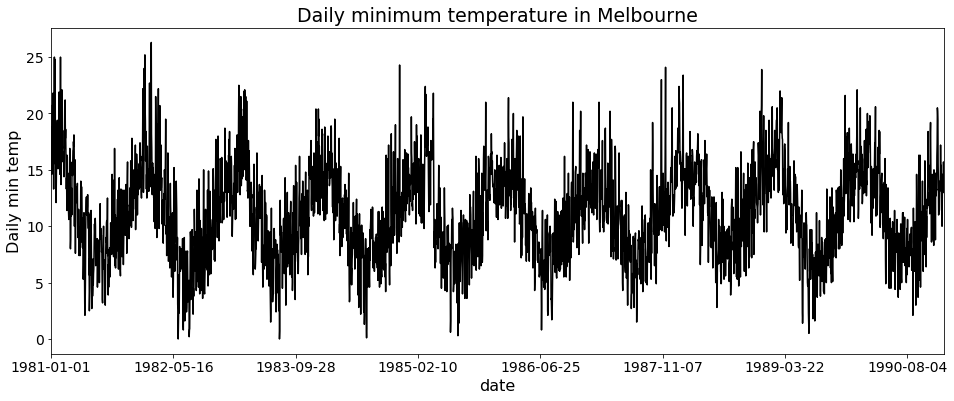

In [4]:
plot = temp_data_df.plot(
    kind = 'line',
    linestyle='-',
    color='black',
    ms=7,
    x = 'date',
    y = 'daily_min_temp',
    figsize = (16,6),
    fontsize=14,
    title = 'Daily minimum temperature in Melbourne',
    legend = False,
    #rot = 0,
)
plot.set_ylabel('Daily min temp', fontsize=16)
plot.set_xlabel('date', fontsize=16)
plot.title.set_fontsize(19)

### Conclusions:
### - Temperature data is (very) periodic

## Predict tomorrow's temperature based on previous day?

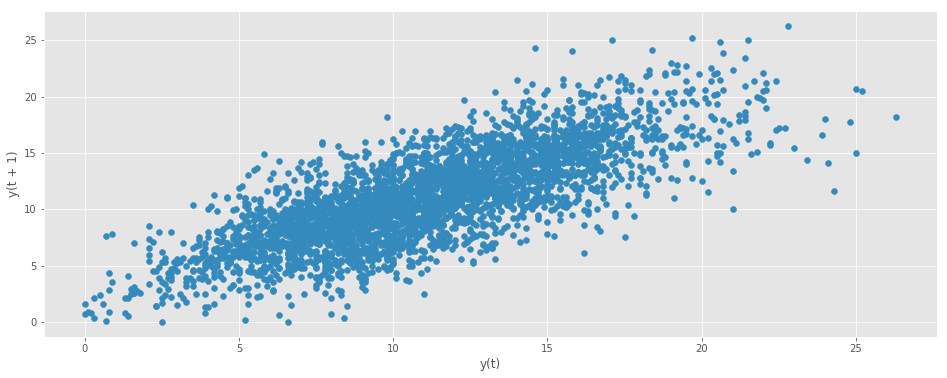

In [5]:
plt.rcParams['figure.figsize']=(16,6)
plt.style.use('ggplot')

pd.plotting.lag_plot(temp_data_df['daily_min_temp'], lag=1)

### Is that good enough? Should we consider a larger lookback window? How many lag terms do we choose?

## Autocorrelation

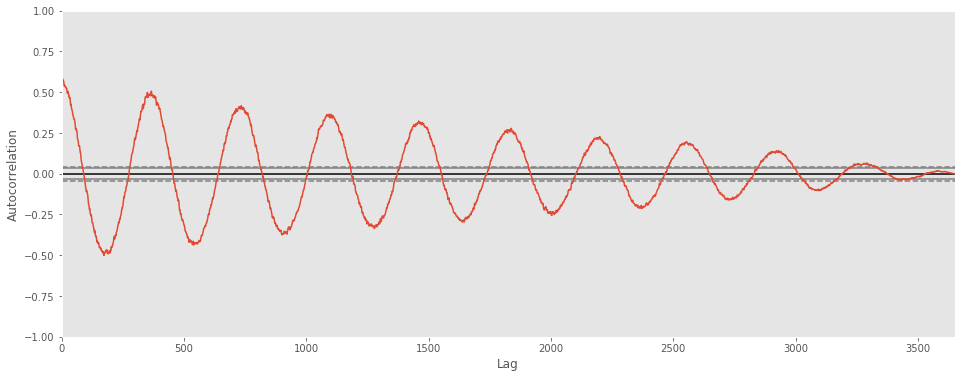

In [6]:
pd.plotting.autocorrelation_plot(temp_data_df['daily_min_temp'])

### Conclusions:
### - There is definitely a correlation in the time series... not surprising since daily min temp is a periodic function

## Let's look at a smaller lag window...

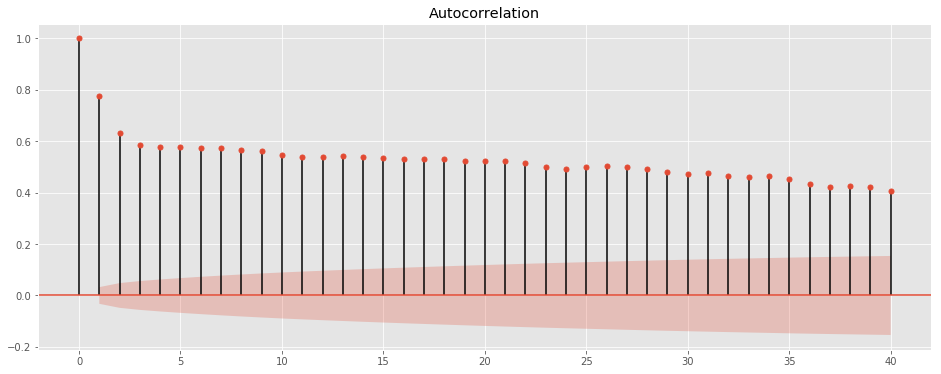

In [7]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = temp_data_df['daily_min_temp']
plot_acf(series, lags=40)
pyplot.show()

### Conclusions:
### - Now we have an idea of how many terms to include... let's do an autoregression! 

## Autoregression on daily min temp data (7 day forecast let's say)

### Let's test performance

In [8]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

num_predictions = 7

series = temp_data_df['daily_min_temp']

# split dataset
X = series.values
train, test = X[1:len(X)-num_predictions], X[len(X)-num_predictions:]

### Use `ar_model` in `statsmodel`. But again, how do we choose appropriate lag?
### - `ar_model` defaults to round(12 * (nobs/100.)**0.25 )..... (random???)
### - you can set lag to a value you choose based on autocorrelation analysis
### - you can also set an information criterion when fitting to choose the "best" lag... (`ic= {'aic', 'bic', 'hqic', 't-stat'})

### Let's try out some fitting....

In [9]:
# train autoregression
model = AR(train)

# default
model_fit = model.fit()
print('Default fitting:')
print('Lag chosen = {} = round(12 * (3650/100)**0.25)'.format(model_fit.k_ar))
print('-'*40)

# choose a lag
model_fit = model.fit(maxlag=4)
print('Choose your own lag:')
print('Lag chosen = {}'.format(model_fit.k_ar))
print('-'*40)

# aic
model_fit = model.fit(ic='aic')
print('aic:')
print('Lag chosen = {}'.format(model_fit.k_ar))
print('-'*40)

# bic
model_fit = model.fit(ic='bic')
print('bic:')
print('Lag chosen = {}'.format(model_fit.k_ar))
print('-'*40)

# hqic
model_fit = model.fit(ic='hqic')
print('hqic:')
print('Lag chosen = {}'.format(model_fit.k_ar))
print('-'*40)

# t-stat
model_fit = model.fit(ic='t-stat')
print('t-stat:')
print('Lag chosen = {}'.format(model_fit.k_ar))
print('-'*40)

#model_fit = model.fit(maxlag=4)#(ic='aic') # aic, bic, hqic, t-stat (this one uses autocorr confidence, see docs)
# note with no ic specified, fit choose lag to be round(12*(nobs/100.)**(1/4.))
#lag_chosen = model_fit.k_ar
#model_params = model_fit.params
#print('Lag chosen = {}'.format(lag_chosen))
#print('Coefficients =\n {}'.format(model_params))

Default fitting:
Lag chosen = 29 = round(12 * (3650/100)**0.25)
----------------------------------------
Choose your own lag:
Lag chosen = 4
----------------------------------------
aic:
Lag chosen = 21
----------------------------------------
bic:
Lag chosen = 13
----------------------------------------
hqic:
Lag chosen = 18
----------------------------------------
t-stat:
Lag chosen = 25
----------------------------------------


### So... which information criterion do we choose?.... Probably try them all and test them

### Let's just stick with the random default for all intents and purposes...

In [10]:
# train autoregression
model = AR(train)
model_fit = model.fit()#(ic='aic') # aic, bic, hqic, t-stat (this one uses autocorr confidence, see docs)
# note with no ic specified, fit choose lag to be round(12*(nobs/100.)**(1/4.))
lag_chosen = model_fit.k_ar
model_params = model_fit.params
print('Lag chosen = {}'.format(lag_chosen))
print('Coefficients =\n {}'.format(model_params))

Lag chosen = 29
Coefficients =
 [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]


### Test 7 day forecast against what is expected for last 7 days of time series

In [11]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# tbh, not sure what dyanmic does... 
percent_error_per_test_obs = 100. * (predictions - test) / np.abs(test)
for i in range(len(test)):
    print('predicted = {:10.4f}, expected = {:10.4f}, %error = {:6.2f}%'.format(predictions[i], test[i], percent_error_per_test_obs[i]))
    
MSE = mean_squared_error(test, predictions)
print('Test MSE = {}'.format(MSE))
RMSE = np.sqrt(MSE)
print('Test RMSE = {}'.format(RMSE))
MAE = mean_absolute_error(test, predictions)
print('Mean abs error = {}'.format(MAE))

predicted =    11.8713, expected =    12.9000, %error =  -7.97%
predicted =    13.0538, expected =    14.6000, %error = -10.59%
predicted =    13.5326, expected =    14.0000, %error =  -3.34%
predicted =    13.2431, expected =    13.6000, %error =  -2.62%
predicted =    13.0914, expected =    13.5000, %error =  -3.03%
predicted =    13.1470, expected =    15.7000, %error = -16.26%
predicted =    13.1762, expected =    13.0000, %error =   1.36%
Test MSE = 1.5015252310070237
Test RMSE = 1.2253673861365104
Mean abs error = 0.9338485873978778


### * Note: AR uses it's own predictions when forecasting y(t+1)

### Conclusions:
### - Not too bad... perhaps better than the weather network.... :haha:

### More visual comparison:

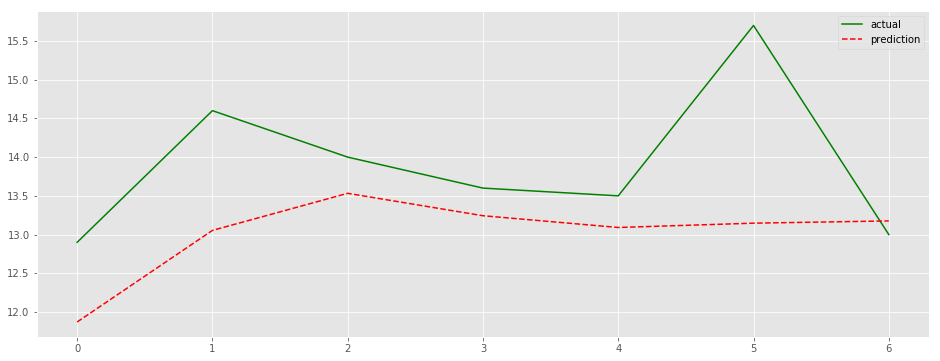

In [12]:
# plot comparison results
pyplot.plot(test, color='green', label='actual')
pyplot.plot(predictions, color='red', linestyle='--', label='prediction')
pyplot.legend(loc='best')
pyplot.show()

## Once you choose your model with "best" fit params, forecast the next N days past end of time series data

In [13]:
num_next_timesteps = 7

series = temp_data_df['daily_min_temp'].values

model = AR(series)
model_fit = model.fit(ic='t-stat')#(ic='aic') # aic, bic, hqic, t-stat (this one uses autocorr confidence, see docs)
# note with no ic specified, fit choose lag to be round(12*(nobs/100.)**(1/4.))
lag_chosen = model_fit.k_ar
model_params = model_fit.params
print('Lag chosen = {}'.format(lag_chosen))
print('Coefficients =\n {}'.format(model_params))

# make prediction
predictions = model_fit.predict(start=len(series), end=len(series)+num_next_timesteps-1, dynamic=False)
for i in range(0,num_next_timesteps):
    print('predicted = {:10.4f}'.format(predictions[i]))


Lag chosen = 25
Coefficients =
 [ 5.78625936e-01  5.89690642e-01 -9.08689186e-02  4.78509821e-02
  3.95048194e-02  4.01092582e-02  2.68327752e-02  4.52932348e-02
  1.44583596e-02  3.82907747e-02  1.55470060e-05  5.51596530e-03
  1.94232884e-02  2.70603567e-02  8.71452520e-04  2.43111569e-02
  7.65050938e-03  1.13220721e-02  3.59695911e-02 -8.17598593e-03
  2.54490988e-02  2.08156036e-02  1.35226159e-02 -1.58950233e-02
 -3.45943725e-03  3.19668564e-02]
predicted =    13.0286
predicted =    13.3354
predicted =    13.4544
predicted =    13.4176
predicted =    13.3882
predicted =    13.3484
predicted =    13.3832


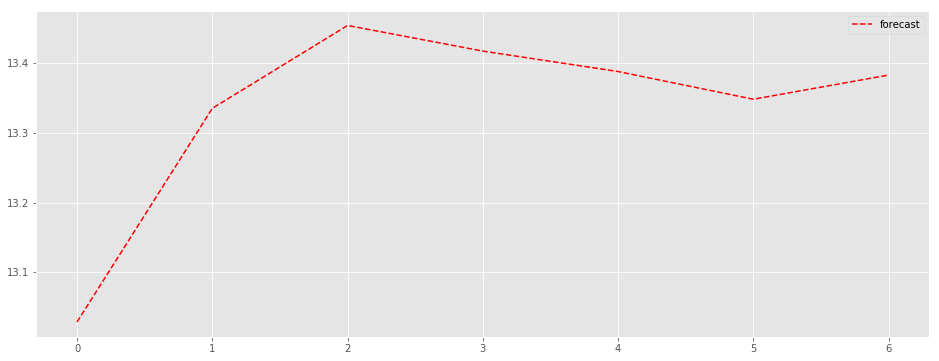

In [14]:
# plot forecast
pyplot.plot(predictions, color='red', linestyle='--', label='forecast')
pyplot.legend(loc='best')
pyplot.show()

# Example 2 - Google stock price

In [15]:
google_data_df = pd.read_csv('data/google_stock.txt', delim_whitespace=True, encoding='utf-16')

In [16]:
print(google_data_df.shape)

(105, 2)


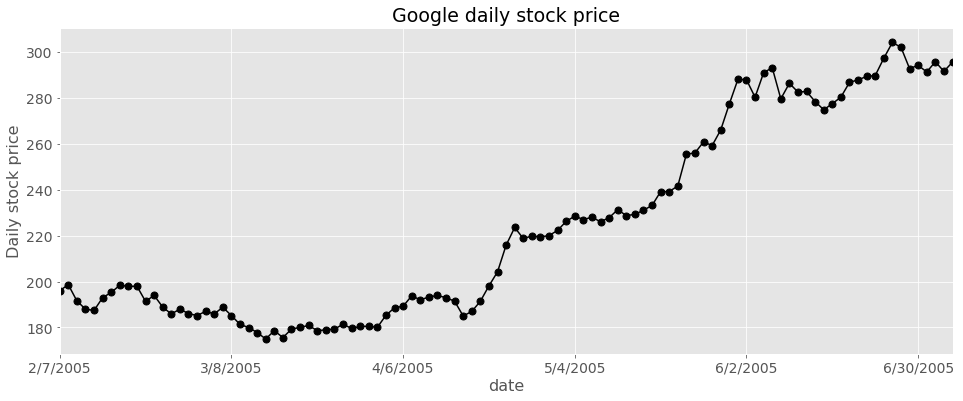

In [17]:
plot = google_data_df.plot(
    kind = 'line',
    linestyle='-',
    color='black',
    marker='o',
    ms=7,
    x = 'date',
    y = 'price',
    figsize = (16,6),
    fontsize=14,
    title = 'Google daily stock price',
    legend = False,
    #rot = 0,
)
plot.set_ylabel('Daily stock price', fontsize=16)
plot.set_xlabel('date', fontsize=16)
plot.title.set_fontsize(19)

## Autocorrelation

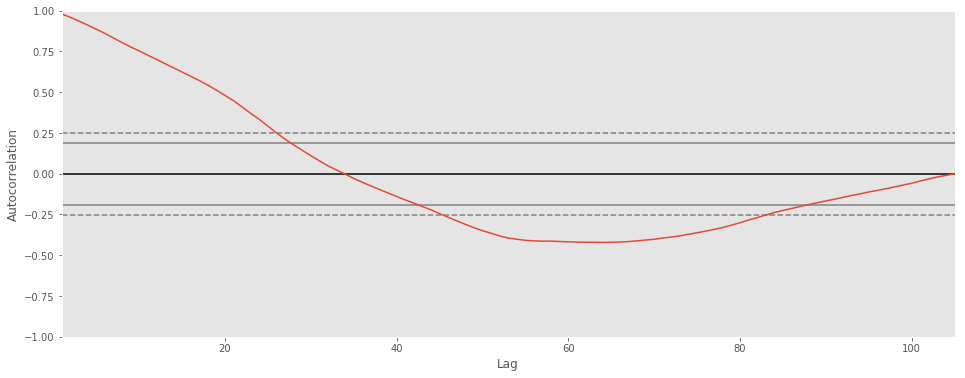

In [18]:
pd.plotting.autocorrelation_plot(google_data_df['price'])

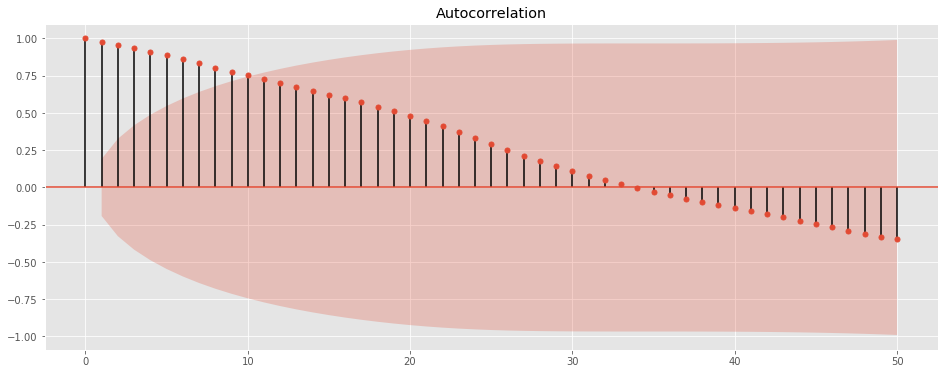

In [19]:
series = google_data_df['price']
plot_acf(series, lags=50)
pyplot.show()

## Autoregression testing

In [20]:
num_predictions = 7

series = google_data_df['price']

# split dataset
X = series.values
train, test = X[1:len(X)-num_predictions], X[len(X)-num_predictions:]

# train autoregression
model = AR(train)
model_fit = model.fit(ic='t-stat')#(ic='aic') # aic, bic, hqic, t-stat (this one uses autocorr confidence, see docs)
# note with no ic specified, fit choose lag to be round(12*(nobs/100.)**(1/4.))
lag_chosen = model_fit.k_ar
model_params = model_fit.params
print('Lag chosen = {}'.format(lag_chosen))
print('Coefficients =\n {}'.format(model_params))

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# tbh, not sure what dyanmic does... 
percent_error_per_test_obs = 100. * (predictions - test) / np.abs(test)
for i in range(len(test)):
    print('predicted = {:10.4f}, expected = {:10.4f}, %error = {:6.2f}%'.format(predictions[i], test[i], percent_error_per_test_obs[i]))
    
MSE = mean_squared_error(test, predictions)
print('Test MSE = {}'.format(MSE))
RMSE = np.sqrt(MSE)
print('Test RMSE = {}'.format(RMSE))
MAE = mean_absolute_error(test, predictions)
print('Mean abs error = {}'.format(MAE))

Lag chosen = 1
Coefficients =
 [-2.49343149  1.0163954 ]
predicted =   306.5924, expected =   302.0000, %error =   1.52%
predicted =   309.1257, expected =   292.7200, %error =   5.60%
predicted =   311.7005, expected =   294.1500, %error =   5.97%
predicted =   314.3175, expected =   291.2500, %error =   7.92%
predicted =   316.9774, expected =   295.7100, %error =   7.19%
predicted =   319.6810, expected =   291.5200, %error =   9.66%
predicted =   322.4289, expected =   295.5400, %error =   9.10%
Test MSE = 442.67474627976554
Test RMSE = 21.039837125789866
Mean abs error = 19.704771582755175


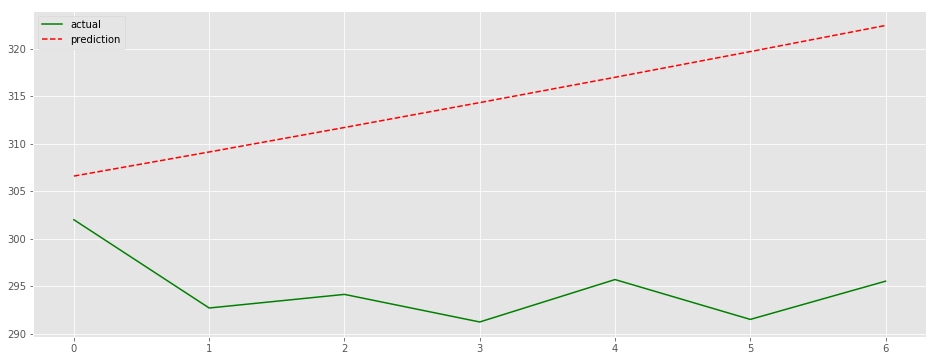

In [21]:
# plot comparison results
pyplot.plot(test, color='green', label='actual')
pyplot.plot(predictions, color='red', linestyle='--', label='prediction')
pyplot.legend(loc='best')
pyplot.show()

## Autoregression forecasting

In [22]:
num_next_timesteps = 7

series = google_data_df['price'].values

model = AR(series)
model_fit = model.fit(ic='t-stat')#(ic='aic') # aic, bic, hqic, t-stat (this one uses autocorr confidence, see docs)
# note with no ic specified, fit choose lag to be round(12*(nobs/100.)**(1/4.))
lag_chosen = model_fit.k_ar
model_params = model_fit.params
print('Lag chosen = {}'.format(lag_chosen))
print('Coefficients =\n {}'.format(model_params))

# make prediction
predictions = model_fit.predict(start=len(series), end=len(series)+num_next_timesteps-1, dynamic=False)
for i in range(0,num_next_timesteps):
    print('predicted = {:10.4f}'.format(predictions[i]))

Lag chosen = 1
Coefficients =
 [-0.35845344  1.00587089]
predicted =   296.9166
predicted =   298.3013
predicted =   299.6942
predicted =   301.0952
predicted =   302.5044
predicted =   303.9220
predicted =   305.3478


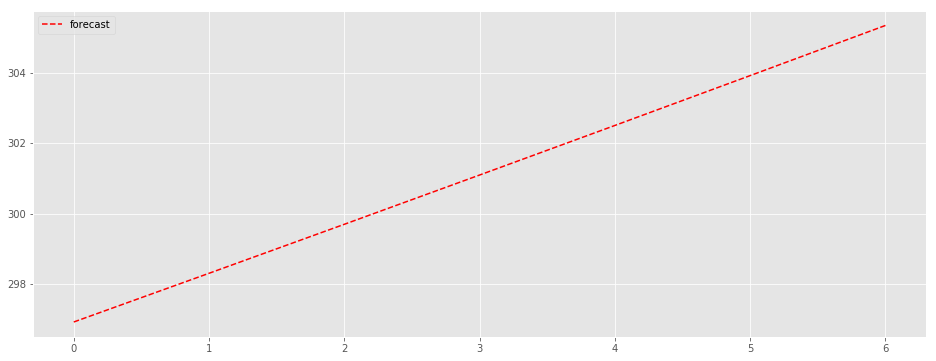

In [23]:
# plot forecast
pyplot.plot(predictions, color='red', linestyle='--', label='forecast')
pyplot.legend(loc='best')
pyplot.show()

# Example 3 - Retail sales data

In [24]:
retail_data_df = pd.read_csv('data/retail_sales.csv')

In [25]:
print(retail_data_df.shape)

(72, 2)


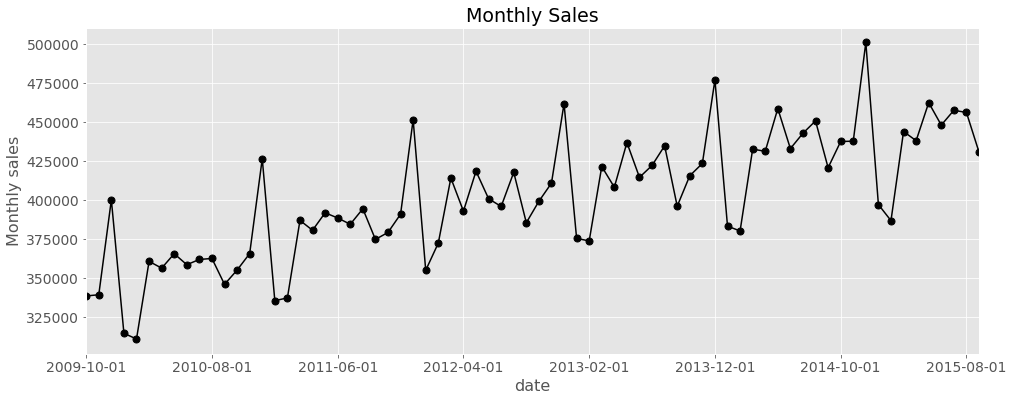

In [26]:
plot = retail_data_df.plot(
    kind = 'line',
    linestyle='-',
    color='black',
    marker='o',
    ms=7,
    x = 'date',
    y = 'sales',
    figsize = (16,6),
    fontsize=14,
    title = 'Monthly Sales',
    legend = False,
    #rot = 0,
)
plot.set_ylabel('Monthly sales', fontsize=16)
plot.set_xlabel('date', fontsize=16)
plot.title.set_fontsize(19)

## Autocorrelation

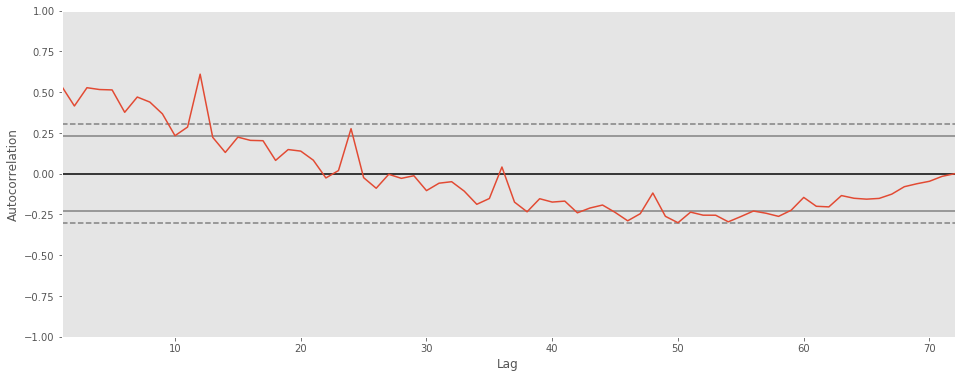

In [27]:
pd.plotting.autocorrelation_plot(retail_data_df['sales'])

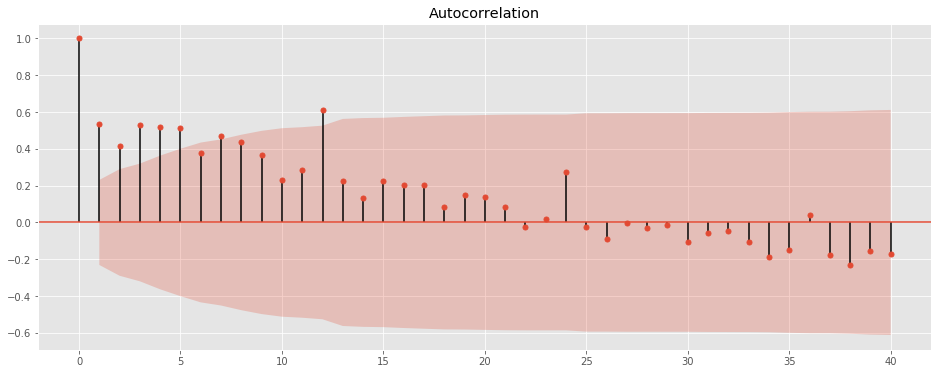

In [28]:
series = retail_data_df['sales']
plot_acf(series, lags=40)
pyplot.show()

## Autoregression testing

In [29]:
num_predictions = 12

series = retail_data_df['sales']

# split dataset
X = series.values
train, test = X[1:len(X)-num_predictions], X[len(X)-num_predictions:]

# train autoregression
model = AR(train)
model_fit = model.fit(ic='t-stat')#(ic='aic') # aic, bic, hqic, t-stat (this one uses autocorr confidence, see docs)
# note with no ic specified, fit choose lag to be round(12*(nobs/100.)**(1/4.))
lag_chosen = model_fit.k_ar
model_params = model_fit.params
print('Lag chosen = {}'.format(lag_chosen))
print('Coefficients =\n {}'.format(model_params))

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# tbh, not sure what dyanmic does... 
percent_error_per_test_obs = 100. * (predictions - test) / np.abs(test)
for i in range(len(test)):
    print('predicted = {:10.4f}, expected = {:10.4f}, %error = {:6.2f}%'.format(predictions[i], test[i], percent_error_per_test_obs[i]))
    
MSE = mean_squared_error(test, predictions)
print('Test MSE = {}'.format(MSE))
RMSE = np.sqrt(MSE)
print('Test RMSE = {}'.format(RMSE))
MAE = mean_absolute_error(test, predictions)
print('Mean abs error = {}'.format(MAE))

Lag chosen = 11
Coefficients =
 [ 2.84989813e+03 -2.96217990e-01 -2.73076308e-01  1.77255472e-01
  2.86117407e-01  6.56511276e-01  4.61527245e-01  5.79592518e-01
  2.25755411e-01  4.55379999e-02 -4.51795146e-01 -3.99311947e-01]
predicted = 427252.3361, expected = 437702.0000, %error =  -2.39%
predicted = 465466.9577, expected = 437910.0000, %error =   6.29%
predicted = 500775.6106, expected = 501232.0000, %error =  -0.09%
predicted = 450917.8457, expected = 397252.0000, %error =  13.51%
predicted = 429402.8711, expected = 386935.0000, %error =  10.98%
predicted = 450719.6246, expected = 444110.0000, %error =   1.49%
predicted = 465054.2777, expected = 438217.0000, %error =   6.12%
predicted = 480801.1368, expected = 462615.0000, %error =   3.93%
predicted = 468122.8633, expected = 448229.0000, %error =   4.44%
predicted = 478880.2044, expected = 457710.0000, %error =   4.63%
predicted = 480040.5976, expected = 456340.0000, %error =   5.19%
predicted = 456335.5570, expected = 430917.000

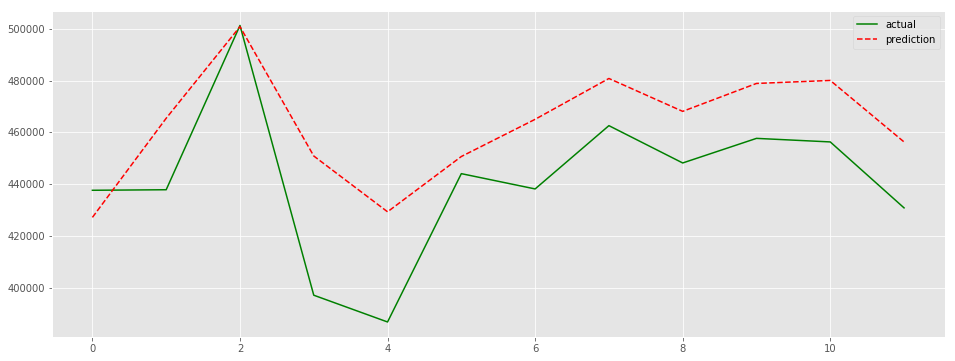

In [30]:
# plot comparison results
pyplot.plot(test, color='green', label='actual')
pyplot.plot(predictions, color='red', linestyle='--', label='prediction')
pyplot.legend(loc='best')
pyplot.show()

## Autoregression forecasting

In [31]:
num_next_timesteps = 12

series = retail_data_df['sales'].values

model = AR(series)
model_fit = model.fit(ic='t-stat')#(ic='aic') # aic, bic, hqic, t-stat (this one uses autocorr confidence, see docs)
# note with no ic specified, fit choose lag to be round(12*(nobs/100.)**(1/4.))
lag_chosen = model_fit.k_ar
model_params = model_fit.params
print('Lag chosen = {}'.format(lag_chosen))
print('Coefficients =\n {}'.format(model_params))

# make prediction
predictions = model_fit.predict(start=len(series), end=len(series)+num_next_timesteps-1, dynamic=False)
for i in range(0,num_next_timesteps):
    print('predicted = {:10.4f}'.format(predictions[i]))

Lag chosen = 10
Coefficients =
 [ 5.97317456e+04 -9.25321240e-02 -3.20942703e-01  1.06403953e-01
  3.50978990e-02  4.81561783e-01  1.35212740e-01  5.03557819e-01
  1.58468286e-01  1.87939057e-01 -3.17096643e-01]
predicted = 420535.5326
predicted = 463339.3403
predicted = 487946.6460
predicted = 447942.0003
predicted = 444456.8145
predicted = 443674.6606
predicted = 454006.1140
predicted = 456643.5127
predicted = 452506.1362
predicted = 471311.6200
predicted = 465785.9756
predicted = 447740.8722


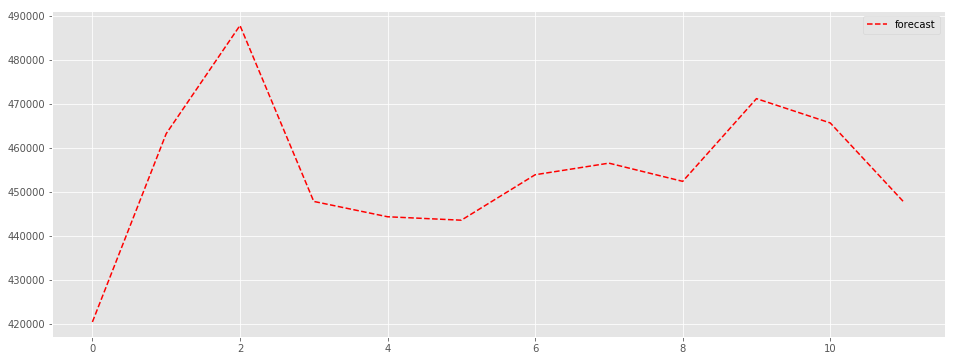

In [32]:
# plot forecast
pyplot.plot(predictions, color='red', linestyle='--', label='forecast')
pyplot.legend(loc='best')
pyplot.show()